<div>
  <h1 style="text-align:center;">Learning from Multi-label data</h1>
    <h2 style="text-align:left;"> Objective </h2>
    <p>This notebook focused on multilabel classification using the DeliciousMil dataset. The primary objective is to compare the performance of various machine learning models when combined with the ChainClassifier approach.</p>
<h2>Dataset Overview</h2>
    <p>The DeliciousMil dataset serves as the foundation for our analysis. It comprises a collection of documents, each associated with multiple labels. The dataset is widely used in the field of text classification and provides an excellent opportunity to evaluate the performance of different models.</p>
  
  <h2 style="text-align:left;">Feature Extraction</h2>
  <p>To facilitate the multilabel classification task, we employ the TF-IDF (Term Frequency-Inverse Document Frequency) technique to transform the documents into numerical feature vectors. The TF-IDF approach calculates the importance of each word in a document by considering both its frequency within the document and its rarity across the entire dataset. This transformation enables us to represent the textual data in a format suitable for training machine learning models.</p>
  
  <h2 style="text-align:left;">Models and Approaches</h2>
  <p>In this notebook, we focus on the ChainClassifier approach combined with various machine learning models for multilabel classification. The ChainClassifier considers the label order and dependencies when making predictions. It trains a sequence of binary classifiers, where the prediction of each classifier is conditioned on the predictions of the previous classifiers. This approach captures the label correlations present in the data.</p>
  <p>We compare the performance of the ChainClassifier combined with the following machine learning models:</p>
  <ol>
    <li>LogisticRegression</li>
    <li>DecisionTreeClassifier</li>
    <li>RandomForestClassifier</li>
    <li>KNeighborsClassifier</li>
  </ol>
  <p>Additionally, we evaluate an ensemble decision by combining the predictions of the above models. This ensemble approach aims to leverage the strengths of individual models and enhance the overall classification performance.</p>
  
  <h2 style="text-align:left;">Scope</h2>
  <p>Throughout this notebook, we will perform the following tasks:</p>
  <ol>
    <li>Data loading and preprocessing: We load the DeliciousMil dataset, examine its structure, and perform any necessary preprocessing steps.</li>
    <li>Feature extraction: We employ the TF-IDF technique to convert the text documents into numerical feature vectors, making them suitable for model training.</li>
    <li>Model training and evaluation: We train the ChainClassifier combined with the logistic regression, decision tree, random forest, and K-nearest neighbors classifiers. We evaluate the performance of each model using appropriate evaluation metrics.</li>
    <li>Ensemble decision: We combine the predictions of the individual models to create an ensemble decision and evaluate its performance.</li>
    <li>Performance analysis: We compare the performance of the different models and the ensemble decision using appropriate evaluation metrics, such as accuracy, precision, recall, and F1-score. This analysis helps us identify the most effective model and approach for the multilabel classification task
       
</div>

## Package imports

In [5]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import zero_one_loss, coverage_error, label_ranking_loss, label_ranking_average_precision_score, accuracy_score, classification_report, precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split

## System configuration

In [6]:
Datapath = './data'

train_data_file = '%s/train-data.dat' %Datapath
train_label_file = '%s/train-label.dat' %Datapath
test_data_file = '%s/test-data.dat' %Datapath
test_label_file = '%s/test-label.dat' %Datapath
vocabfile = '%s/vocabs.txt' %Datapath
trslblfile = '%s/train-sentlabel.dat' %Datapath
tslblfile = '%s/test-sentlabel.dat' %Datapath
label_names_file = '%s/labels.txt' %Datapath


## Read data

In [7]:
# read docs and corresponding labels
def read_data(data_path, label_path):
    labels = []
    features = []
    documents = []
    with open(data_path, 'r') as f:
        for doc in f:
            doc = re.sub(r"<.*?>", "", doc)
            doc = doc.replace("\n", "").strip()
            documents.append(doc)
    
    labels = np.loadtxt(label_path).astype(int)
    return documents, labels

def read_label_names(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    df = pd.DataFrame(columns=['label'])

    for line in lines:
        label, index = line.strip().split(', ')
        df = pd.concat([df, pd.DataFrame({'label': [label], 'index': [index]})], ignore_index=True)

    df.set_index('index', inplace=True)
    return df

def read_vocabulary(file_path):
    word_dict = {}

    with open(file_path, "r") as f:
        for line in f:
            tokens = line.split(",")

            word_dict[tokens[0].strip()] = int(tokens[1].strip())

    return word_dict

In [8]:
def _read_labels(label_file):
        labels = []

        with open(label_file, "r") as f:
            for line in f:
                line = line.strip()

                labels.append([int(v) for v in line.split()])

        return labels
fixed_labels = _read_labels(train_label_file)

In [9]:
train_docs, train_labels = read_data(train_data_file, train_label_file)
test_docs, test_labels = read_data(test_data_file, test_label_file)

print("X_train documents list size: ", len(train_docs))
print("X_test documents list size: ", len(test_docs))

X_train documents list size:  8251
X_test documents list size:  3983


In [6]:
vocab = read_vocabulary(vocabfile)
print(f"Vocabulary size: {len(vocab.values())}")

Vocabulary size: 8520


In [7]:
label_name_df = read_label_names(label_names_file)
label_name_df.head()

,label
index,
0,programming
1,style
2,reference
3,java
4,web


## Data Exploration

In [8]:
Y_train = pd.DataFrame(columns=label_name_df['label'].to_list(),data=train_labels)
Y_test = pd.DataFrame(columns=label_name_df['label'].to_list(),data=test_labels)
Y_train.head()

,programming,style,reference,java,web,internet,culture,design,education,language,books,writing,computer,english,politics,history,philosophy,science,religion,grammar
0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0
4,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
def plot_label_occurences(df):
    counts = df.sum()
    counts.plot(kind='bar')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Label Occurrences')
    plt.show()
    
def plot_multilabel_combinations(df):
    df["num_of_labels"] = df.sum(axis=1)
    # Count the number of occurrences of each value in the 'sum' column
    counts = df['num_of_labels'].value_counts()

    # Create a bar plot of the value occurrences
    counts.plot(kind='bar')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title('Different Multilabel Combination Occurrences')
    plt.show()

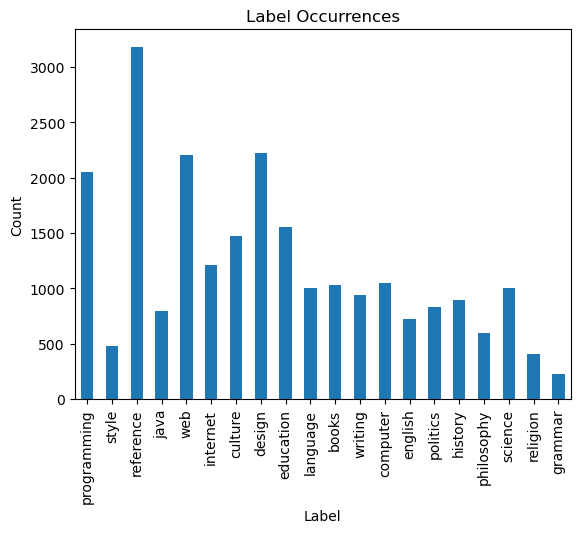

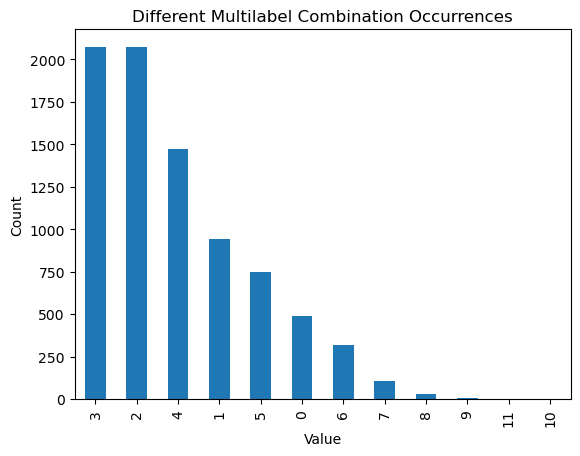

In [10]:
plot_label_occurences(df=Y_train.copy())
plot_multilabel_combinations(df=Y_train.copy())

In [11]:
def show_labels_correlation(df):
    correlation_df = pd.DataFrame(df.corr().unstack(), columns=['correlation'])
    correlation_df = correlation_df[correlation_df['correlation'] != 1]

    # Sort the correlations in descending order
    strongest_correlations = correlation_df.sort_values(by='correlation',key=lambda x: abs(x), ascending=False)

    unique_correlations = strongest_correlations.drop_duplicates(subset='correlation')

    print(unique_correlations.head(10))
    return unique_correlations
    
def get_corr_ordered_list(unique_correlations: pd.DataFrame):
    index_list = list(unique_correlations.index)

    unique_list = []

    def add_to_list(item):
        if item not in unique_list:
            unique_list.append(item)

    for tup in index_list:
        add_to_list(tup[0])
        add_to_list(tup[1])

    return unique_list

def extract_ordered_indexes(column_names, dataframe):
    matching_indexes = []
    for name in column_names:
        if name in dataframe.columns:
            matching_indexes.append(dataframe.columns.get_loc(name))
    return matching_indexes

In [12]:
unique_corr_df = show_labels_correlation(Y_train)
unique_corr_list = get_corr_ordered_list(unique_corr_df)

                         correlation
programming java            0.417753
language    english         0.410899
internet    web             0.348891
language    grammar         0.343873
english     grammar         0.338019
writing     english         0.275664
design      web             0.258805
web         programming     0.243235
education   english         0.242792
politics    culture         0.241102


In [13]:
unique_corr_list[0:5]

['programming', 'java', 'language', 'english', 'internet']

In [14]:
ordered_indexes = extract_ordered_indexes(unique_corr_list, Y_train)
ordered_indexes

[0, 3, 9, 13, 5, 4, 19, 11, 7, 8, 14, 6, 10, 15, 17, 16, 18, 1, 12, 2]

## Preprocessing

In [15]:
def apply_vectorization(x_train, x_test, vocabulary, vec_type: str = "tf-idf"):
    if vec_type == "tf-idf":
        print("Applied tf-idf vectorization...")
        tfidf_vectorizer = TfidfVectorizer()
        X_train_transformed = tfidf_vectorizer.fit_transform(x_train)
        X_test_transformed = tfidf_vectorizer.transform(x_test)
        vocabulary = tfidf_vectorizer.get_feature_names_out()
    elif vec_type == "count":
        print("Applied count vectorization...")
        vectorizer = CountVectorizer(vocabulary=vocabulary)
        X_train_transformed = vectorizer.fit_transform(x_train)
        X_test_transformed = vectorizer.transform(x_test)
        vocab = vectorizer.get_feature_names_out()
    else:
        raise TypeError("Not valid vec type")

    print("Vocabulary size: ",len(vocabulary))
    print("X train count shape: ", X_train_transformed.shape)
    print("X test count shape: ", X_test_transformed.shape)
    return X_train_transformed, X_test_transformed

In [16]:
X_train_transformed, X_test_transformed = apply_vectorization(x_train=train_docs, x_test=test_docs,
                                                              vocabulary=vocab, vec_type="tf-idf")

Applied tf-idf vectorization...
Vocabulary size:  8510
X train count shape:  (8251, 8510)
X test count shape:  (3983, 8510)


## Dimensionality reduction

In [17]:
def find_number_of_components(X_tfidf):    
    # Apply Truncated SVD to find optimal number of components
    svd = TruncatedSVD(n_components=X_tfidf.shape[1]-1)  # max number of components
    svd.fit(X_tfidf)

    # Find number of components needed to explain 95% of the variance
    variance_ratios = svd.explained_variance_ratio_
    cumulative_variance_ratios = np.cumsum(variance_ratios)
    n_components = np.argmax(cumulative_variance_ratios > 0.95) + 1
    print(f"Number of components needed to explain 95% of variance: {n_components}")

In [18]:
def apply_dimensionality_reduction(n_components, x_train, x_test):
    svd = TruncatedSVD(n_components=n_components)
    X_train_svd = svd.fit_transform(x_train)
    X_test_svd = svd.transform(x_test)
    return X_train_svd, X_test_svd, svd

In [23]:
# x_train_svd, x_test_svd, svd = apply_dimensionality_reduction(3000, X_train_transformed, X_test_transformed)
# print("x train reduced: ", x_train_svd.shape)
# print("x test reduced: ", x_test_svd.shape)

x train reduced:  (8251, 3000)
x test reduced:  (3983, 3000)


## Classifier Chain Ensemble

In [19]:

def train_chains(x_train, y_train, x_test, y_test):
    
    model_names = ["LogisticRegression", "BalancedLogisticRegr","DecisionTreeClassifier", "RandomForestClassifier",
                   "SupportVectorClassifier"]
    classifiers = [LogisticRegression(random_state=13, solver='newton-cg'),
                   LogisticRegression(random_state=13, solver='saga', class_weight='balanced'),
                   DecisionTreeClassifier(), RandomForestClassifier(), SVC(kernel='linear')]
    target_names = list(y_train.columns)

    # OneVsRest Classifier
    ovr = OneVsRestClassifier(LogisticRegression(solver='newton-cg'))
    print("Training OneVsRest Classifier...")
    ovr.fit(x_train, y_train)
    Y_pred_ovr = ovr.predict(x_test)
    ovr_scores = precision_recall_fscore_support(y_test, Y_pred_ovr, average="samples")

    # Chain models
    chains = [ClassifierChain(clf, order="random", random_state=13, verbose=True) for clf in classifiers]
    for name, chain in tqdm(zip(model_names, chains)):
        print(f"Train chain - {name}...")
        chain.fit(x_train, y_train)

    Y_pred_chains = np.array([chain.predict(x_test) for chain in tqdm(chains, desc="Chains predicting...")])
    
    chain_scores = [precision_recall_fscore_support(y_test, Y_pred_chain, average='samples')
                    for Y_pred_chain in Y_pred_chains]
    
    # add OneVsRest
    model_names.insert(0, "OneVsRest")
    chain_scores.insert(0, ovr_scores)
    
    # Ensemble
    Y_pred_ensemble = Y_pred_chains.mean(axis=0)
    Y_pred_ensemble = np.where(Y_pred_ensemble >= 0.5, 1, 0)
    model_names.append('ensemble')
    
    
    ensemble_scores = precision_recall_fscore_support(Y_test, Y_pred_ensemble, average='samples')
    chain_scores.append(ensemble_scores)
    models_scores = dict(zip(model_names, chain_scores))

    return models_scores

In [20]:
model_scores = train_chains(X_train_transformed, Y_train, X_test_transformed, Y_test)


Training OneVsRest Classifier...


C:\Users\mlsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mlsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0it [00:00, ?it/s]

Train chain - LogisticRegression...
[Chain] ................. (1 of 20) Processing order 11, total=   0.4s
[Chain] ................. (2 of 20) Processing order 12, total=   0.4s
[Chain] .................. (3 of 20) Processing order 0, total=   0.5s
[Chain] .................. (4 of 20) Processing order 1, total=   0.5s
[Chain] .................. (5 of 20) Processing order 8, total=   0.6s
[Chain] .................. (6 of 20) Processing order 5, total=   0.7s
[Chain] .................. (7 of 20) Processing order 7, total=   1.0s
[Chain] ................. (8 of 20) Processing order 15, total=   0.7s
[Chain] ................. (9 of 20) Processing order 14, total=   1.0s
[Chain] ................ (10 of 20) Processing order 13, total=   1.3s
[Chain] ................. (11 of 20) Processing order 3, total=   1.2s
[Chain] ................ (12 of 20) Processing order 17, total=   1.5s
[Chain] ................. (13 of 20) Processing order 9, total=   2.1s
[Chain] ................. (14 of 20) Proc

C:\Users\mlsal\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Chain] ................. (1 of 20) Processing order 11, total=   2.3s
[Chain] ................. (2 of 20) Processing order 12, total=   0.6s
[Chain] .................. (3 of 20) Processing order 0, total=   0.4s


C:\Users\mlsal\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Chain] .................. (4 of 20) Processing order 1, total=   1.6s
[Chain] .................. (5 of 20) Processing order 8, total=   0.4s
[Chain] .................. (6 of 20) Processing order 5, total=   0.4s
[Chain] .................. (7 of 20) Processing order 7, total=   0.3s
[Chain] ................. (8 of 20) Processing order 15, total=   0.4s
[Chain] ................. (9 of 20) Processing order 14, total=   0.4s
[Chain] ................ (10 of 20) Processing order 13, total=   0.4s
[Chain] ................. (11 of 20) Processing order 3, total=   0.4s
[Chain] ................ (12 of 20) Processing order 17, total=   0.4s
[Chain] ................. (13 of 20) Processing order 9, total=   0.4s
[Chain] ................. (14 of 20) Processing order 4, total=   0.4s
[Chain] ................. (15 of 20) Processing order 2, total=   0.5s
[Chain] ................. (16 of 20) Processing order 6, total=   0.4s


C:\Users\mlsal\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Chain] ................ (17 of 20) Processing order 19, total=   1.2s
[Chain] ................ (18 of 20) Processing order 10, total=   0.4s
[Chain] ................ (19 of 20) Processing order 16, total=   0.6s


C:\Users\mlsal\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Chain] ................ (20 of 20) Processing order 18, total=   1.3s
Train chain - DecisionTreeClassifier...
[Chain] ................. (1 of 20) Processing order 11, total=  18.0s
[Chain] ................. (2 of 20) Processing order 12, total=  16.2s
[Chain] .................. (3 of 20) Processing order 0, total=  20.7s
[Chain] .................. (4 of 20) Processing order 1, total=  19.5s
[Chain] .................. (5 of 20) Processing order 8, total=  16.0s
[Chain] .................. (6 of 20) Processing order 5, total=  22.3s
[Chain] .................. (7 of 20) Processing order 7, total=  12.6s
[Chain] ................. (8 of 20) Processing order 15, total=  10.0s
[Chain] ................. (9 of 20) Processing order 14, total=   7.1s
[Chain] ................ (10 of 20) Processing order 13, total=  10.7s
[Chain] ................. (11 of 20) Processing order 3, total=   5.5s
[Chain] ................ (12 of 20) Processing order 17, total=  13.0s
[Chain] ................. (13 of 20) 

Chains predicting...:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\mlsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mlsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mlsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mlsal\anaconda3\lib\site-packages\sklearn\metrics\_cla

In [21]:
def plot_models_comparison(model_scores: dict):
    metric_names = ['Precision', 'Recall', 'F1']
    model_names = list(model_scores.keys())
    x_pos = np.arange(len(model_names))
    for metric_name in metric_names:
        scores = [val[metric_names.index(metric_name)] for key, val in model_scores.items()]

        fig, ax = plt.subplots(figsize=(7, 4))
        ax.grid(True)
        ax.set_title(f"{metric_name} score - Classifier Chain Ensemble Performance Comparison")
        ax.set_xticks(x_pos)
        ax.set_xticklabels(model_names, rotation="vertical")
        ax.set_ylabel(f"{metric_name} Score")
        ax.set_ylim([min(scores) * 0.9, max(scores) * 1.1])
        colors = ["r"] + ["b"] * (len(model_names) - 2) + ["g"]
        ax.bar(x_pos, scores, alpha=0.5, color=colors)
        plt.tight_layout()
        plt.show()

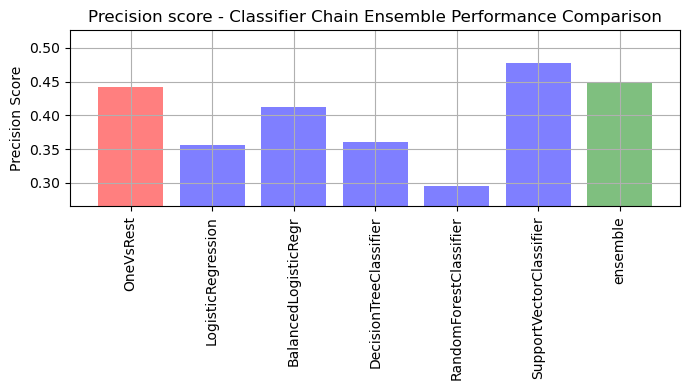

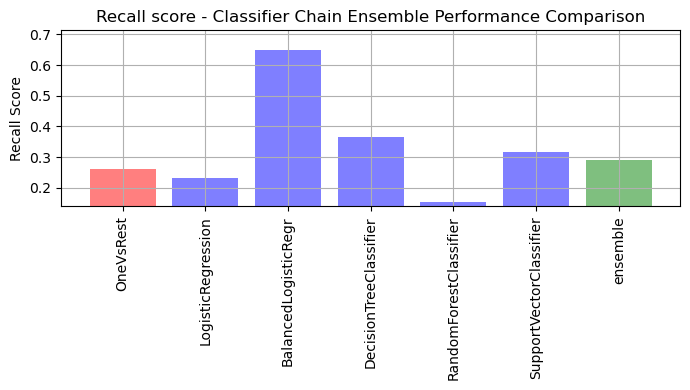

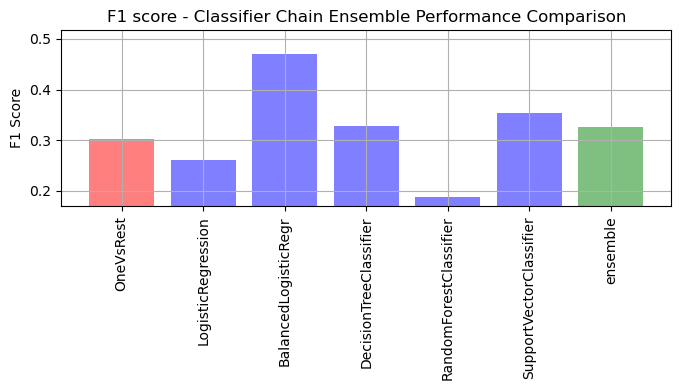

In [22]:
plot_models_comparison(model_scores=model_scores)

### The results of your experiments for multilabel classification

1. **OneVsRestClassifier:**
   - Precision: 0.4427
   - Recall: 0.2603
   - F1-score: 0.3021

2. **LogisticRegression:**
   - Precision: 0.3568
   - Recall: 0.2331
   - F1-score: 0.2602

3. **BalancedLogisticRegr:**
   - Precision: 0.4118
   - Recall: 0.6481
   - F1-score: 0.4699

4. **DecisionTreeClassifier:**
   - Precision: 0.3608
   - Recall: 0.3647
   - F1-score: 0.3283

5. **RandomForestClassifier:**
   - Precision: 0.2948
   - Recall: 0.1554
   - F1-score: 0.1881

6. **SupportVectorClassifier:**
   - Precision: 0.4780
   - Recall: 0.3185
   - F1-score: 0.3530

7. **Ensemble (combination of chain classifiers):**
   - Precision: 0.4491
   - Recall: 0.2906
   - F1-score: 0.3256

### The comparison of the results

- **OneVsRestClassifier:**
   - The model achieved moderate precision, recall, and F1-score.
   - It performs reasonably well but may not be the best choice for this dataset.

- **LogisticRegression:**
   - The precision, recall, and F1-score are relatively low compared to other models.
   - It may not be suitable for this multilabel classification task.

- **BalancedLogisticRegr:**
   - The model achieved higher precision, recall, and F1-score compared to LogisticRegression.
   - The balanced nature of this classifier helps improve performance.

- **DecisionTreeClassifier:**
   - The precision, recall, and F1-score are similar, indicating a balanced performance.
   - However, the scores are not particularly high, suggesting room for improvement.

- **RandomForestClassifier:**
   - The precision, recall, and F1-score are relatively low compared to other models.
   - Random forests may not be the most effective choice for this dataset.

- **SupportVectorClassifier:**
   - The model achieved higher precision, recall, and F1-score compared to most other models.
   - It seems to be a good choice for this multilabel classification task.

- **Ensemble (combination of chain classifiers):**
   - The precision, recall, and F1-score are reasonably good.
   - Combining chain classifiers improves performance compared to individual models.

Overall, the SupportVectorClassifier and the ensemble of chain classifiers show promising results, outperforming other models. It would be worth further investigating and optimizing these models to improve their performance on the multilabel classification task.
